# Life Expectancy by Diet Worldwide

We are going to look at the life expectancies of particular countries. I specifically want to focus on the dietary impacts on how long a person will live. We already know that humans that eat healthier diets live longer.

(two articles citing evidence of such)

https://time.com/4855506/healthy-diet-live-longer/

https://www.nejm.org/doi/full/10.1056/NEJMoa1613502

I would assume that there would then be a correlation between those countries that eat healthier diets and longevity. I would assume that there will be other factors that correlate to life expectancies, but I hope to show that there are high correlations to healthy diets and how long people live.


In [2]:
#imports

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from scipy.stats import norm
from sklearn.model_selection import train_test_split 
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error 
from sklearn.metrics import r2_score 
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

This dataset is from https://www.kaggle.com/kumarajarshi/life-expectancy-who and lists countries of the world and their life expectancy among other considerations.

In [6]:
life_expectancy_df=pd.read_csv("https://raw.githubusercontent.com/Aaron-Tee/Life_Expectancy_and_Foods_Worldwide/main/Life%20Expectancy%20Data.csv")
print(life_expectancy_df.head())

       Country  Year      Status  Life expectancy   Adult Mortality  \
0  Afghanistan  2015  Developing              65.0            263.0   
1  Afghanistan  2014  Developing              59.9            271.0   
2  Afghanistan  2013  Developing              59.9            268.0   
3  Afghanistan  2012  Developing              59.5            272.0   
4  Afghanistan  2011  Developing              59.2            275.0   

   infant deaths  Alcohol  percentage expenditure  Hepatitis B  Measles   ...  \
0             62     0.01               71.279624         65.0      1154  ...   
1             64     0.01               73.523582         62.0       492  ...   
2             66     0.01               73.219243         64.0       430  ...   
3             69     0.01               78.184215         67.0      2787  ...   
4             71     0.01                7.097109         68.0      3013  ...   

   Polio  Total expenditure  Diphtheria    HIV/AIDS         GDP  Population  \
0    6.

This dataset is was found from https://www.globaldietarydatabase.org/complete-survey-metadataand lists countries of the world and their dietary consumptions.

In [7]:
food_df=pd.read_csv("https://raw.githubusercontent.com/Aaron-Tee/Life_Expectancy_and_Foods_Worldwide/main/GDD%20Dec2020%20Survey%20Metadata%201611c.csv")
print(food_df.head())

                                         Survey name  \
0          Demographic and Health Survey Angola 2011   
1                                              DHS V   
2    Global Student Based Student Health Survey 2010   
3  United Arab Emirate- Indoor Air, Health and Nu...   
4    Global Student Based Student Health Survey 2005   

  Availability of dietary data ISO3    Year Dietary assessment method  \
0           Publicly Available  AGO  2011.0                 Biomarker   
1           Publicly Available  ALB  2008.0         DHS Questionnaire   
2           Publicly Available  ARE  2010.0                       FFQ   
3                          NaN  ARE  2009.0             Single Recall   
4           Publicly Available  ARE  2005.0                       FFQ   

  Representativeness  Sample size  Youngest age  Oldest age          Sex  \
0           National       2888.0           0.0         4.0  Male|Female   
1           National      16638.0           0.0        98.0  Male|Female

Each of the prior datasets lists countries of the world but one labels them as with their 'ISO3' which is an abbreviation, and the other lists the countries by name. This third dataset is one where we will use to match the name of the country with its 'ISO3' abbreviation.

In [8]:
country_codes_df=pd.read_csv("https://raw.githubusercontent.com/Aaron-Tee/Life_Expectancy_and_Foods_Worldwide/main/country-codes_csv.csv")
print(country_codes_df.head())

  FIFA   Dial ISO3166-1-Alpha-3 MARC   is_independent  ISO3166-1-numeric GAUL  \
0  TPE    886               TWN   ch              Yes              158.0  925   
1  AFG     93               AFG   af              Yes                4.0    1   
2  ALB    355               ALB   aa              Yes                8.0    3   
3  ALG    213               DZA   ae              Yes               12.0    4   
4  ASA  1-684               ASM   as  Territory of US               16.0    5   

  FIPS  WMO ISO3166-1-Alpha-2  ...  Sub-region Name    official_name_ru  \
0   TW  NaN                TW  ...              NaN                 NaN   
1   AF   AF                AF  ...    Southern Asia          Афганистан   
2   AL   AB                AL  ...  Southern Europe             Албания   
3   AG   AL                DZ  ...  Northern Africa               Алжир   
4   AQ  NaN                AS  ...        Polynesia  Американское Самоа   

  Global Name    Capital Continent  TLD          Languages Geo

Now we will work with the food dataset and drop any columns that are not needed such as the survey that was used, and the survey website/link.

In [9]:
food_df=food_df.drop(['Survey name', 'Availability of dietary data',
       'Dietary assessment method', 'Representativeness', 'Sample size',
       'Youngest age', 'Oldest age', 'Sex',
       'FoodEx2 harmonization status', 'GDD model inclusion?',
       'URL (public surveys only)', 'surveyid', 'surveyround'], axis=1)
print(type(food_df), food_df.shape, food_df.columns, food_df.info(),food_df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1611 entries, 0 to 1610
Data columns (total 3 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   ISO3                       1611 non-null   object 
 1   Year                       1535 non-null   float64
 2   Available dietary factors  1221 non-null   object 
dtypes: float64(1), object(2)
memory usage: 37.9+ KB
<class 'pandas.core.frame.DataFrame'> (1611, 3) Index(['ISO3', 'Year', 'Available dietary factors'], dtype='object') None               Year
count  1535.000000
mean   2001.927036
std       8.210077
min    1980.000000
25%    1997.000000
50%    2003.000000
75%    2008.000000
max    2017.000000


As we are simply looking for most likely dietary culprits, we can drop the rows that there is no data present, NaN's.

In [10]:
food_df=food_df.dropna()
print(food_df.isnull().sum())

ISO3                         0
Year                         0
Available dietary factors    0
dtype: int64


The column "Available dietary factors" has fields that are both separated by "," and "|". We can usually use the formula (food_df=food_df["Available dietary factors"].str.split('|', expand=True)) to separate the objects into separate columns.In this case, the fields do not separate correctly. Also I tried (food_df=pd.get_dummies(food_df["Available dietary factors"])) which did not work either.I needed to open up the food.csv in "Notebook", and look for how many different factors were included in the column. I then created another CSV notebook with each of the fields separated by a comma.

In [11]:
dietary_df=pd.read_csv("https://raw.githubusercontent.com/Aaron-Tee/Data_files_used/main/List%20of%20dietary%20potential%20sources.csv")
print(dietary_df.head())

Empty DataFrame
Columns: [Unnamed: 0, Non-Starchy Vegetables,  Other Starchy Vegetables,  Beans and Legumes,  Sugar-Sweetened Beverages,  Unprocessed Red Meats,  Total Seafoods,  Trans Fatty Acid,  Refined Grains,  Total Milk,  Coffee,  Fruits,  Dietary Sodium,  Vitamin A without Supplements,  Vitamin A with Supplements,  Vitamin B12,  Eggs,  Cheese,  Monounsaturated Fat,  Total Carbohydrates,  Saturated Fat,  Total Processed Meats,  Nuts and Seeds,  Fruit Juice,  Dietary Cholesterol,  Whole Grains,  Potatoes,  Yogurt,  Tea,  Dietary Fiber,  Calcium,  Whole Fat Milk,  Reduced Fat Milk,  Seafood Omega-3 Fat,  Total Omega-6 Fatty Acids,  Plant Omega-3 Fat,  Total Energy,  Total Protein,  Potassium,  Iron,  Vitamin B1,  Vitamin C,  Animal Protein,  Dairy Protein,  Plant Protein,  Added Sugars,  Magnesium,  Vitamin B3,  Selenium,  Iodine,  Vitamin B2,  Vitamin B6,  Vitamin B9,  Vitamin D,  Vitamin E,  Zinc,  Glycemic Index,  Glycemic Load]
Index: []

[0 rows x 58 columns]


With lots of trial and error, I decided the simplest thing to do was to create a list of the dietary sources that are in the food_df["Available dietary factors"]. I then took the list of the sources and created a list of "foods" with the column dietary factors.

In [12]:
foods =["Non-Starchy Vegetables","Other Starchy Vegetables","Beans and Legumes",\
                             "Sugar-Sweetened Beverages","Unprocessed Red Meats","Total Seafoods","Trans Fatty Acid",\
                             "Refined Grains","Total Milk","Coffee","Fruits","Dietary Sodium","Vitamin A without Supplements",\
                             "Vitamin A with Supplements","Vitamin B12","Eggs","Cheese","Monounsaturated Fat",\
                             "Total Carbohydrates","Saturated Fat","Total Processed Meats","Nuts and Seeds","Fruit Juice",\
                             "Dietary Cholesterol","Whole Grains","Potatoes","Yogurt","Tea","Dietary Fiber","Calcium",\
                             "Whole Fat Milk","Reduced Fat Milk","Seafood Omega-3 Fat","Total Omega-6 Fatty Acids",\
                             "Plant Omega-3 Fat","Total Energy","Total Protein","Potassium","Iron","Vitamin B1","Vitamin C",\
                             "Animal Protein","Dairy Protein","Plant Protein","Added Sugars","Magnesium","Vitamin B3",\
                             "Selenium","Iodine","Vitamin B2","Vitamin B6","Vitamin B9","Vitamin D","Vitamin E","Zinc"]
foods

['Non-Starchy Vegetables',
 'Other Starchy Vegetables',
 'Beans and Legumes',
 'Sugar-Sweetened Beverages',
 'Unprocessed Red Meats',
 'Total Seafoods',
 'Trans Fatty Acid',
 'Refined Grains',
 'Total Milk',
 'Coffee',
 'Fruits',
 'Dietary Sodium',
 'Vitamin A without Supplements',
 'Vitamin A with Supplements',
 'Vitamin B12',
 'Eggs',
 'Cheese',
 'Monounsaturated Fat',
 'Total Carbohydrates',
 'Saturated Fat',
 'Total Processed Meats',
 'Nuts and Seeds',
 'Fruit Juice',
 'Dietary Cholesterol',
 'Whole Grains',
 'Potatoes',
 'Yogurt',
 'Tea',
 'Dietary Fiber',
 'Calcium',
 'Whole Fat Milk',
 'Reduced Fat Milk',
 'Seafood Omega-3 Fat',
 'Total Omega-6 Fatty Acids',
 'Plant Omega-3 Fat',
 'Total Energy',
 'Total Protein',
 'Potassium',
 'Iron',
 'Vitamin B1',
 'Vitamin C',
 'Animal Protein',
 'Dairy Protein',
 'Plant Protein',
 'Added Sugars',
 'Magnesium',
 'Vitamin B3',
 'Selenium',
 'Iodine',
 'Vitamin B2',
 'Vitamin B6',
 'Vitamin B9',
 'Vitamin D',
 'Vitamin E',
 'Zinc']

I now need to create columns for each of the "Available dietary factors" in the food Dataframe. This way I can determine which foods each country is more likely to consume. This is a loop that lists each item from the foods. List and then inserts that "item" as "a" into the lambda command.  The command then creates a new column for each "item". We can now see that some countries consume different "foods".

In [13]:
while len(foods):
        a = foods.pop(0)
        food_df[a] = food_df["Available dietary factors"].map(lambda x: "1" if a\
                                                                             in x else '0').astype(float)
# print dataframe
food_df

,ISO3,Year,Available dietary factors,Non-Starchy Vegetables,Other Starchy Vegetables,Beans and Legumes,Sugar-Sweetened Beverages,Unprocessed Red Meats,Total Seafoods,Trans Fatty Acid,...,Magnesium,Vitamin B3,Selenium,Iodine,Vitamin B2,Vitamin B6,Vitamin B9,Vitamin D,Vitamin E,Zinc
1,ALB,2008.0,Fruits|Non-Starchy Vegetables|Other Starchy Ve...,1.0,1.0,1.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,ARE,2010.0,Fruits|Non-Starchy Vegetables|Sugar-Sweetened ...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,ARE,2009.0,Total Energy|Total Carbohydrates|Total Protein...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,ARE,2005.0,Fruits|Non-Starchy Vegetables|Fruits|Non-Starc...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,ARE,2003.0,Fruits|Non-Starchy Vegetables|Fruits|Non-Starc...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1592,USA,2003.0,Fruits|Non-Starchy Vegetables|Beans and Legume...,1.0,0.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1593,USA,2001.0,Fruits|Non-Starchy Vegetables|Beans and Legume...,1.0,0.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1595,USA,1999.0,Fruits|Non-Starchy Vegetables|Beans and Legume...,1.0,0.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1597,VGB,2009.0,Fruits|Non-Starchy Vegetables|Sugar-Sweetened ...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
# drop the "Available dietary factors" column in the food_df.

food_df=food_df.drop(["Available dietary factors"], axis=1)
print(food_df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1216 entries, 1 to 1608
Data columns (total 57 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   ISO3                           1216 non-null   object 
 1   Year                           1216 non-null   float64
 2   Non-Starchy Vegetables         1216 non-null   float64
 3   Other Starchy Vegetables       1216 non-null   float64
 4   Beans and Legumes              1216 non-null   float64
 5   Sugar-Sweetened Beverages      1216 non-null   float64
 6   Unprocessed Red Meats          1216 non-null   float64
 7   Total Seafoods                 1216 non-null   float64
 8   Trans Fatty Acid               1216 non-null   float64
 9   Refined Grains                 1216 non-null   float64
 10  Total Milk                     1216 non-null   float64
 11  Coffee                         1216 non-null   float64
 12  Fruits                         1216 non-null   f

We must now begin to look at merging the DataFrames with the "ISO" and the country name. First I want to remove any unnecessary data from country_codes_df.

In [15]:
country_codes_df=country_codes_df.drop(['FIFA', 'Dial', 'MARC', 'is_independent','ISO3166-1-numeric', 'GAUL',\
'FIPS', 'WMO', 'ISO3166-1-Alpha-2', 'ITU','IOC', 'DS', 'UNTERM Spanish Formal', 'Global Code','Intermediate Region Code',\
'official_name_fr', 'UNTERM French Short','ISO4217-currency_name','UNTERM Russian Formal', 'UNTERM English Short',\
'ISO4217-currency_alphabetic_code','Small Island Developing States (SIDS)', 'UNTERM Spanish Short',\
'ISO4217-currency_numeric_code', 'UNTERM Chinese Formal','UNTERM French Formal', 'UNTERM Russian Short', 'M49',\
'Sub-region Code', 'Region Code', 'official_name_ar','ISO4217-currency_minor_unit', 'UNTERM Arabic Formal',\
'UNTERM Chinese Short', 'Land Locked Developing Countries (LLDC)','Intermediate Region Name',\
'official_name_cn', 'ISO4217-currency_country_name',"official_name_es","UNTERM English Formal",\
'Least Developed Countries (LDC)', 'Region Name', 'UNTERM Arabic Short','official_name_ru', 'Global Name', 'Capital',\
'TLD', 'Languages', 'Geoname ID','EDGAR'], axis=1)

country_codes_df

,ISO3166-1-Alpha-3,Developed / Developing Countries,official_name_en,Sub-region Name,Continent,CLDR display name
0,TWN,NaN,NaN,NaN,AS,Taiwan
1,AFG,Developing,Afghanistan,Southern Asia,AS,Afghanistan
2,ALB,Developed,Albania,Southern Europe,EU,Albania
3,DZA,Developing,Algeria,Northern Africa,AF,Algeria
4,ASM,Developing,American Samoa,Polynesia,OC,American Samoa
...,...,...,...,...,...,...
245,ESH,Developing,Western Sahara,Northern Africa,AF,Western Sahara
246,YEM,Developing,Yemen,Western Asia,AS,Yemen
247,ZMB,Developing,Zambia,Sub-Saharan Africa,AF,Zambia
248,ZWE,Developing,Zimbabwe,Sub-Saharan Africa,AF,Zimbabwe


Now to fix the country_code_df to make it more readable. 
Changing the 'Developed / Developing Countries' column to a boolean and changing the column names.

In [16]:
country_codes_df["Developing Countries"]= country_codes_df['Developed / Developing Countries'].map(
                   {'Developing':1 ,'Developed':0})
country_codes_df["Developing Countries"]= country_codes_df["Developing Countries"]
country_codes_df["ISO3"]= country_codes_df["ISO3166-1-Alpha-3"]
country_codes_df=country_codes_df.drop(['Developed / Developing Countries', "ISO3166-1-Alpha-3", ], axis=1)

country_codes_df

,official_name_en,Sub-region Name,Continent,CLDR display name,Developing Countries,ISO3
0,NaN,NaN,AS,Taiwan,NaN,TWN
1,Afghanistan,Southern Asia,AS,Afghanistan,1.0,AFG
2,Albania,Southern Europe,EU,Albania,0.0,ALB
3,Algeria,Northern Africa,AF,Algeria,1.0,DZA
4,American Samoa,Polynesia,OC,American Samoa,1.0,ASM
...,...,...,...,...,...,...
245,Western Sahara,Northern Africa,AF,Western Sahara,1.0,ESH
246,Yemen,Western Asia,AS,Yemen,1.0,YEM
247,Zambia,Sub-Saharan Africa,AF,Zambia,1.0,ZMB
248,Zimbabwe,Sub-Saharan Africa,AF,Zimbabwe,1.0,ZWE


I now have a Dataframe with all of the prior separated fields as their own columns. 
Now I'm going to merge the two Dataframes on the "ISO3" column.

In [17]:
food_codes_df = pd.merge(left=food_df, right=country_codes_df, left_on='ISO3', right_on='ISO3')

food_codes_df

,ISO3,Year,Non-Starchy Vegetables,Other Starchy Vegetables,Beans and Legumes,Sugar-Sweetened Beverages,Unprocessed Red Meats,Total Seafoods,Trans Fatty Acid,Refined Grains,...,Vitamin B6,Vitamin B9,Vitamin D,Vitamin E,Zinc,official_name_en,Sub-region Name,Continent,CLDR display name,Developing Countries
0,ALB,2008.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,Albania,Southern Europe,EU,Albania,0.0
1,ARE,2010.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,United Arab Emirates,Western Asia,AS,United Arab Emirates,1.0
2,ARE,2009.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,1.0,1.0,1.0,1.0,United Arab Emirates,Western Asia,AS,United Arab Emirates,1.0
3,ARE,2005.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,United Arab Emirates,Western Asia,AS,United Arab Emirates,1.0
4,ARE,2003.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,United Arab Emirates,Western Asia,AS,United Arab Emirates,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1211,NRU,2011.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,Nauru,Micronesia,OC,Nauru,1.0
1212,PRI,2010.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,Puerto Rico,Latin America and the Caribbean,NaN,Puerto Rico,1.0
1213,PRI,2002.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,Puerto Rico,Latin America and the Caribbean,NaN,Puerto Rico,1.0
1214,TUV,2013.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,Tuvalu,Polynesia,OC,Tuvalu,1.0


In [18]:
#Remove any columns that are expected to be unnecessary.

life_expectancy_df=life_expectancy_df.drop(['Status', 'percentage expenditure', 'Hepatitis B', 'Measles ',\
                                        'under-five deaths ', 'Polio', 'Total expenditure', 'Diphtheria ',\
                                        ' HIV/AIDS', 'GDP',' thinness  1-19 years', ' thinness 5-9 years',\
                                        'Income composition of resources'], axis=1)

life_expectancy_df

,Country,Year,Life expectancy,Adult Mortality,infant deaths,Alcohol,BMI,Population,Schooling
0,Afghanistan,2015,65.0,263.0,62,0.01,19.1,33736494.0,10.1
1,Afghanistan,2014,59.9,271.0,64,0.01,18.6,327582.0,10.0
2,Afghanistan,2013,59.9,268.0,66,0.01,18.1,31731688.0,9.9
3,Afghanistan,2012,59.5,272.0,69,0.01,17.6,3696958.0,9.8
4,Afghanistan,2011,59.2,275.0,71,0.01,17.2,2978599.0,9.5
...,...,...,...,...,...,...,...,...,...
2933,Zimbabwe,2004,44.3,723.0,27,4.36,27.1,12777511.0,9.2
2934,Zimbabwe,2003,44.5,715.0,26,4.06,26.7,12633897.0,9.5
2935,Zimbabwe,2002,44.8,73.0,25,4.43,26.3,125525.0,10.0
2936,Zimbabwe,2001,45.3,686.0,25,1.72,25.9,12366165.0,9.8


In [19]:
# Merge life_expectancy_df with food_codes_df on life_expectancy_df['Country'] and food_codes_df["official_name_en"]

df = pd.merge(left=food_codes_df, right=life_expectancy_df, left_on=["official_name_en","Year"], right_on=['Country',"Year"])

We now have 750 rows within the Dataset. Remove duplicate years and countries by their ISO3 name.

In [20]:
df=df.sort_values(by=['ISO3', 'Year'])
df=df.drop_duplicates(subset=['ISO3', 'Year'], keep='last')
df=df.drop_duplicates(subset=['ISO3'], keep='last').reset_index()
df=df.drop(['index','Population','official_name_en'], axis=1)

df = df.dropna().reset_index()

nan_values = df[df.isnull().any(axis=1)]
df=df.drop(['index', 'CLDR display name'], axis=1)

print(df)

    ISO3    Year  Non-Starchy Vegetables  Other Starchy Vegetables  \
0    ALB  2008.0                     1.0                       1.0   
1    ARE  2010.0                     1.0                       0.0   
2    ARG  2012.0                     1.0                       0.0   
3    ARM  2010.0                     1.0                       0.0   
4    AUS  2011.0                     0.0                       0.0   
..   ...     ...                     ...                       ...   
131  VUT  2011.0                     1.0                       0.0   
132  WSM  2011.0                     1.0                       0.0   
133  YEM  2013.0                     1.0                       1.0   
134  ZAF  2007.0                     1.0                       0.0   
135  ZMB  2013.0                     1.0                       1.0   

     Beans and Legumes  Sugar-Sweetened Beverages  Unprocessed Red Meats  \
0                  1.0                        0.0                    1.0   
1      

In [21]:
#Lets expand the database with dummy columns for sub-region name and contient

df = pd.get_dummies(df, columns=['Sub-region Name',"Continent"])

col_name="Life expectancy "
first_col = df.pop(col_name)
df.insert(0, col_name, first_col)

col_name='Country'
sec_col = df.pop(col_name)
df.insert(1, col_name, sec_col)

We now have one row which is the most recent data for each country. Let us check out our Dataframe.

In [22]:
df

,Life expectancy,Country,ISO3,Year,Non-Starchy Vegetables,Other Starchy Vegetables,Beans and Legumes,Sugar-Sweetened Beverages,Unprocessed Red Meats,Total Seafoods,...,Sub-region Name_Southern Asia,Sub-region Name_Southern Europe,Sub-region Name_Sub-Saharan Africa,Sub-region Name_Western Asia,Sub-region Name_Western Europe,Continent_AF,Continent_AS,Continent_EU,Continent_OC,Continent_SA
0,75.3,Albania,ALB,2008.0,1.0,1.0,1.0,0.0,1.0,1.0,...,0,1,0,0,0,0,0,1,0,0
1,76.2,United Arab Emirates,ARE,2010.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0,0,0,1,0,0,1,0,0,0
2,75.9,Argentina,ARG,2012.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1
3,73.5,Armenia,ARM,2010.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0,0,0,1,0,0,1,0,0,0
4,82.0,Australia,AUS,2011.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131,71.2,Vanuatu,VUT,2011.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0,0,0,0,0,0,0,0,1,0
132,73.0,Samoa,WSM,2011.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0,0,0,0,0,0,0,0,1,0
133,65.4,Yemen,YEM,2013.0,1.0,1.0,1.0,0.0,1.0,1.0,...,0,0,0,1,0,0,1,0,0,0
134,54.5,South Africa,ZAF,2007.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0,0,1,0,0,1,0,0,0,0


In [23]:
df.columns

Index(['Life expectancy ', 'Country', 'ISO3', 'Year', 'Non-Starchy Vegetables',
       'Other Starchy Vegetables', 'Beans and Legumes',
       'Sugar-Sweetened Beverages', 'Unprocessed Red Meats', 'Total Seafoods',
       'Trans Fatty Acid', 'Refined Grains', 'Total Milk', 'Coffee', 'Fruits',
       'Dietary Sodium', 'Vitamin A without Supplements',
       'Vitamin A with Supplements', 'Vitamin B12', 'Eggs', 'Cheese',
       'Monounsaturated Fat', 'Total Carbohydrates', 'Saturated Fat',
       'Total Processed Meats', 'Nuts and Seeds', 'Fruit Juice',
       'Dietary Cholesterol', 'Whole Grains', 'Potatoes', 'Yogurt', 'Tea',
       'Dietary Fiber', 'Calcium', 'Whole Fat Milk', 'Reduced Fat Milk',
       'Seafood Omega-3 Fat', 'Total Omega-6 Fatty Acids', 'Plant Omega-3 Fat',
       'Total Energy', 'Total Protein', 'Potassium', 'Iron', 'Vitamin B1',
       'Vitamin C', 'Animal Protein', 'Dairy Protein', 'Plant Protein',
       'Added Sugars', 'Magnesium', 'Vitamin B3', 'Selenium', 'Iodin

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 136 entries, 0 to 135
Data columns (total 86 columns):
 #   Column                                           Non-Null Count  Dtype  
---  ------                                           --------------  -----  
 0   Life expectancy                                  136 non-null    float64
 1   Country                                          136 non-null    object 
 2   ISO3                                             136 non-null    object 
 3   Year                                             136 non-null    float64
 4   Non-Starchy Vegetables                           136 non-null    float64
 5   Other Starchy Vegetables                         136 non-null    float64
 6   Beans and Legumes                                136 non-null    float64
 7   Sugar-Sweetened Beverages                        136 non-null    float64
 8   Unprocessed Red Meats                            136 non-null    float64
 9   Total Seafoods                  

We now have data arranged in such an order that we can now begin to look at the data through charts and graphs.

# Visualizing the Data

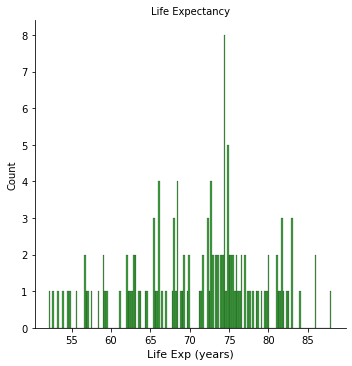

In [25]:
#Basic bar chart looking at life expectancy and how many countries share life expectancy ranges.

sns.displot(df["Life expectancy "], kde=False, color='green', bins=168)
plt.title('Life Expectancy', fontsize=10)
plt.xlabel('Life Exp (years)', fontsize=11)
plt.show()


Looking at life expectancy, we see that the mean value is 71 years old, with 51 and 88 years old at the extremes.

# Checking Correlations

In [26]:
'''Correlations between variables'''
correlation_df = df.corr()
pd.set_option("display.max_rows", None, "display.max_columns", None)

correlation_df["Life expectancy "]


Life expectancy                                    1.000000
Year                                              -0.067026
Non-Starchy Vegetables                            -0.176104
Other Starchy Vegetables                          -0.505057
Beans and Legumes                                 -0.355741
Sugar-Sweetened Beverages                          0.466021
Unprocessed Red Meats                             -0.367839
Total Seafoods                                    -0.362240
Trans Fatty Acid                                   0.095984
Refined Grains                                    -0.452969
Total Milk                                        -0.407769
Coffee                                             0.068741
Fruits                                            -0.176104
Dietary Sodium                                     0.302289
Vitamin A without Supplements                      0.210382
Vitamin A with Supplements                         0.080168
Vitamin B12                             

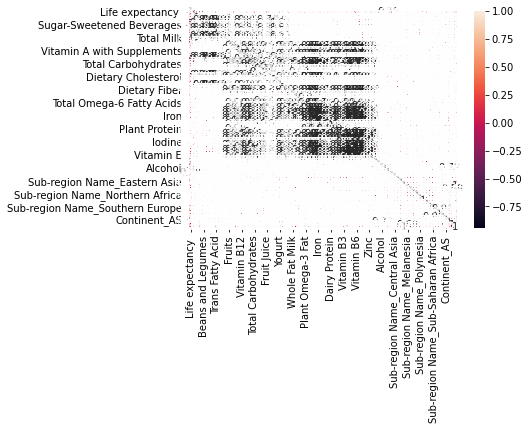

In [27]:
# creating a heat map to see if there are any outstanding patterns.
sns.heatmap(correlation_df, annot=True)
plt.show()

I have noticed that there are many negative and positive correlations. The closer we are to 1.00 or -1.00, the more closely the relationship is between the variables. I am now going to use the absolute values of the correlations to see which factors are most closely associated with life expectancy.

In [28]:
correlation_df["Life expectancy abs "] = correlation_df["Life expectancy "].abs()

sorted_df = correlation_df.sort_values(["Life expectancy abs "], ascending=False)

#df['count'] = df['count'].abs()

sorted_df["Life expectancy abs "]

Life expectancy                                    1.000000
Schooling                                          0.775142
Sub-region Name_Sub-Saharan Africa                 0.726030
Adult Mortality                                    0.669933
Continent_AF                                       0.656736
Developing Countries                               0.576146
Continent_EU                                       0.529519
Other Starchy Vegetables                           0.505057
 BMI                                               0.473552
Sugar-Sweetened Beverages                          0.466021
Yogurt                                             0.457907
Refined Grains                                     0.452969
Alcohol                                            0.410874
Total Milk                                         0.407769
Eggs                                               0.402096
Fruit Juice                                        0.389884
Unprocessed Red Meats                   

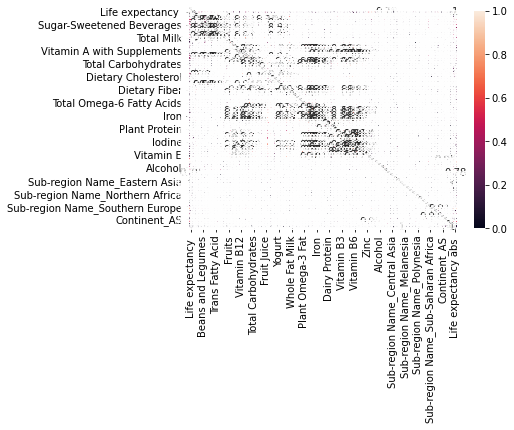

In [29]:
sns.heatmap(correlation_df.abs(), annot=True)
plt.show()

In [30]:
# will reset the print options back to standard
pd.set_option("display.max_rows", 10, "display.max_columns", 20)
df

,Life expectancy,Country,ISO3,Year,Non-Starchy Vegetables,Other Starchy Vegetables,Beans and Legumes,Sugar-Sweetened Beverages,Unprocessed Red Meats,Total Seafoods,...,Sub-region Name_Southern Asia,Sub-region Name_Southern Europe,Sub-region Name_Sub-Saharan Africa,Sub-region Name_Western Asia,Sub-region Name_Western Europe,Continent_AF,Continent_AS,Continent_EU,Continent_OC,Continent_SA
0,75.3,Albania,ALB,2008.0,1.0,1.0,1.0,0.0,1.0,1.0,...,0,1,0,0,0,0,0,1,0,0
1,76.2,United Arab Emirates,ARE,2010.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0,0,0,1,0,0,1,0,0,0
2,75.9,Argentina,ARG,2012.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1
3,73.5,Armenia,ARM,2010.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0,0,0,1,0,0,1,0,0,0
4,82.0,Australia,AUS,2011.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131,71.2,Vanuatu,VUT,2011.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0,0,0,0,0,0,0,0,1,0
132,73.0,Samoa,WSM,2011.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0,0,0,0,0,0,0,0,1,0
133,65.4,Yemen,YEM,2013.0,1.0,1.0,1.0,0.0,1.0,1.0,...,0,0,0,1,0,0,1,0,0,0
134,54.5,South Africa,ZAF,2007.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0,0,1,0,0,1,0,0,0,0


# Visualization based on close correlations with life expectancy

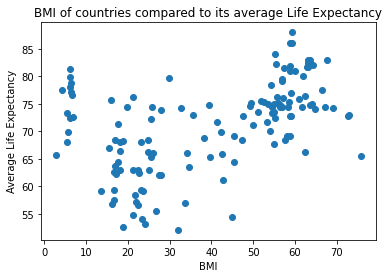

In [31]:
'''Spliting the data'''
X=df.drop("Life expectancy ", axis=1).values
y=df["Life expectancy "].values

'''Prediction: BMI is the feature that is most closely related to Life Expectancy.'''
X_BMI = X[:,62]
yrs=y.reshape(-1,1)
X_BMIrs = X_BMI.reshape(-1,1)

plt.scatter(X_BMIrs,yrs)
plt.xlabel('BMI')
plt.title('BMI of countries compared to its average Life Expectancy')
plt.ylabel('Average Life Expectancy')
plt.show()

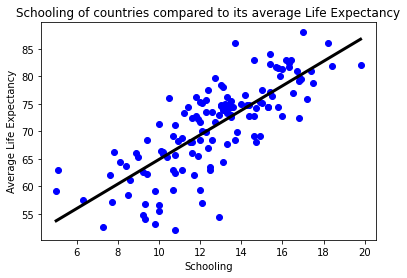

In [32]:
'''Spliting the data'''
X=df.drop("Life expectancy ", axis=1).values
y=df["Life expectancy "].values
'''Prediction: Schooling is the feature that is most closely related to Life Expectancy.'''
X_Schooling = X[:,63]
yrs=y.reshape(-1,1)
X_Schoolingrs = X_Schooling.reshape(-1,1)

'''Creating a Linear Regression line'''
reg= LinearRegression()
reg.fit(X_Schoolingrs, yrs)
prediction_space=np.linspace(min(X_Schoolingrs),max(X_Schoolingrs)).reshape(-1,1)
plt.scatter(X_Schoolingrs, yrs, color="blue")
plt.plot(prediction_space, reg.predict(prediction_space), color="black", linewidth=3)
plt.xlabel('Schooling')
plt.title('Schooling of countries compared to its average Life Expectancy')
plt.ylabel('Average Life Expectancy')
plt.show()

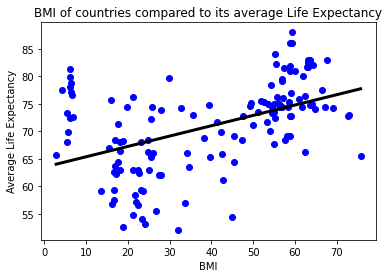

In [33]:

'''Prediction: BMI is the feature that is most closely related to Life Expectancy.'''
X_BMI = X[:,62]
yrs=y.reshape(-1,1)
X_BMIrs = X_BMI.reshape(-1,1)

'''Creating a Linear Regression line'''
reg= LinearRegression()
reg.fit(X_BMIrs, yrs)
prediction_space=np.linspace(min(X_BMIrs),max(X_BMIrs)).reshape(-1,1)
plt.scatter(X_BMIrs, yrs, color="blue")
plt.plot(prediction_space, reg.predict(prediction_space), color="black", linewidth=3)
plt.xlabel('BMI')
plt.title('BMI of countries compared to its average Life Expectancy')
plt.ylabel('Average Life Expectancy')
plt.show()

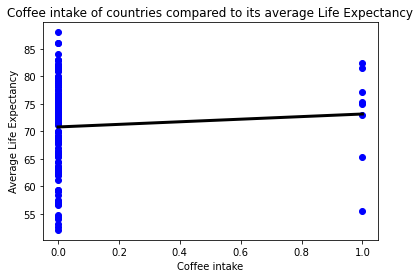

In [34]:

'''Prediction: Coffee is the feature that is most closely related to Life Expectancy.'''
X_Coffee = X[:,12]
yrs=y.reshape(-1,1)
X_Coffeers = X_Coffee.reshape(-1,1)

'''Creating a Linear Regression line'''
reg= LinearRegression()
reg.fit(X_Coffeers, yrs)
prediction_space=np.linspace(min(X_Coffeers),max(X_Coffeers)).reshape(-1,1)
plt.scatter(X_Coffeers, yrs, color="blue")
plt.plot(prediction_space, reg.predict(prediction_space), color="black", linewidth=3)
plt.xlabel('Coffee intake')
plt.title('Coffee intake of countries compared to its average Life Expectancy')
plt.ylabel('Average Life Expectancy')
plt.show()

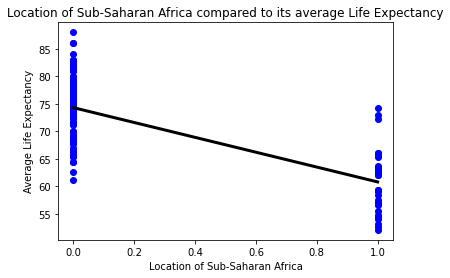

In [35]:

'''Prediction: Sub-Saharan Africa is the feature that is most closely related to Life Expectancy.'''
X_Sub_Saharan_Africa = X[:,77]
yrs=y.reshape(-1,1)
X_Sub_Saharan_Africars = X_Sub_Saharan_Africa.reshape(-1,1)

'''Creating a Linear Regression line'''
reg= LinearRegression()
reg.fit(X_Sub_Saharan_Africars, yrs)
prediction_space=np.linspace(min(X_Sub_Saharan_Africars),max(X_Sub_Saharan_Africars)).reshape(-1,1)
plt.scatter(X_Sub_Saharan_Africars, yrs, color="blue")
plt.plot(prediction_space, reg.predict(prediction_space), color="black", linewidth=3)
plt.xlabel('Location of Sub-Saharan Africa')
plt.title('Location of Sub-Saharan Africa compared to its average Life Expectancy')
plt.ylabel('Average Life Expectancy')
plt.show()

There are correlations that relate to life expectancy that we can see above. The schooling level that a person will reach is the factor that correlates closest (77%) to how long a person will live. BMI only has a 45% correlation. Coffee intake has one of the lowest correlations of 6.8%. The second strongest correlation to life expectancy is if a person lives in Sub-Saharan Africa which is 72%. This is a negative correlation as people tend to live longer if they do not live in the Sub-Saharan Africa region. These are not the factors that I thought would correlate closest to life expectancy.

While these are interesting data relationships. We still want to see if there is a correlation between foods and life expectancy.

Now let us look at two diets, one who would eat meat and all other foods, and the other that eats no animal products. The reason for this analysis is that we know that many scientists have spoken out in the 21st century regarding the negative health impact of eating animal products.

(articles citing evidence for above statement)

https://pubmed.ncbi.nlm.nih.gov/26780279/

https://www.science.org/doi/10.1126/science.aam5324

https://www.healthline.com/nutrition/plant-based-diet-vs-vegan

First, we need to add the correlations of all the foods both with and without absolute values. Then we will add up the correlations of all foods.


In [36]:
correlation_df = df.corr()

correlation_df["Life expectancy abs "] = correlation_df["Life expectancy "].abs()

sorted_df = correlation_df.sort_values(["Life expectancy abs "], ascending=False)

sorted_df["Life expectancy abs "]

Life expectancy                       1.000000
Schooling                             0.775142
Sub-region Name_Sub-Saharan Africa    0.726030
Adult Mortality                       0.669933
Continent_AF                          0.656736
                                        ...   
Sub-region Name_Polynesia             0.029798
Continent_OC                          0.017772
Sub-region Name_Eastern Asia          0.004754
Sub-region Name_Southern Asia         0.003083
Sub-region Name_South-eastern Asia    0.000655
Name: Life expectancy abs , Length: 84, dtype: float64

In [37]:
#List of all Dietary foods and suppliments
Dietall = ['Non-Starchy Vegetables','Other Starchy Vegetables', 'Beans and Legumes','Sugar-Sweetened Beverages', \
           'Unprocessed Red Meats', 'Total Seafoods','Trans Fatty Acid', 'Refined Grains', 'Total Milk', 'Coffee', 'Fruits',\
           'Dietary Sodium', 'Vitamin A without Supplements','Vitamin A with Supplements', 'Vitamin B12', 'Eggs', 'Cheese',\
           'Monounsaturated Fat', 'Total Carbohydrates', 'Saturated Fat', 'Total Processed Meats', 'Nuts and Seeds', \
           'Fruit Juice','Dietary Cholesterol', 'Whole Grains', 'Potatoes', 'Yogurt', 'Tea','Dietary Fiber', 'Calcium', \
           'Whole Fat Milk', 'Reduced Fat Milk', 'Seafood Omega-3 Fat', 'Total Omega-6 Fatty Acids', 'Plant Omega-3 Fat',\
           'Total Energy', 'Total Protein', 'Potassium', 'Iron', 'Vitamin B1','Vitamin C', 'Animal Protein', 'Dairy Protein',\
           'Plant Protein','Added Sugars', 'Magnesium', 'Vitamin B3', 'Selenium', 'Iodine','Vitamin B2', 'Vitamin B6', \
           'Vitamin B9', 'Vitamin D', 'Vitamin E','Zinc']
Dietwoanimal=['Non-Starchy Vegetables','Other Starchy Vegetables', 'Beans and Legumes','Sugar-Sweetened Beverages', \
            'Refined Grains', 'Coffee', 'Fruits','Dietary Sodium', 'Vitamin A without Supplements','Vitamin A with Supplements',\
            'Vitamin B12','Monounsaturated Fat', 'Total Carbohydrates', 'Saturated Fat','Nuts and Seeds', \
           'Fruit Juice','Dietary Cholesterol', 'Whole Grains', 'Potatoes', 'Tea','Dietary Fiber', 'Calcium', \
           'Total Omega-6 Fatty Acids', 'Plant Omega-3 Fat','Total Energy', 'Total Protein', 'Potassium', 'Iron',\
            'Vitamin B1','Vitamin C','Plant Protein','Added Sugars', 'Magnesium', 'Vitamin B3', 'Selenium', 'Iodine',\
            'Vitamin B2', 'Vitamin B6','Vitamin B9', 'Vitamin D', 'Vitamin E','Zinc']
Dietwoanimalhealthy=['Non-Starchy Vegetables','Other Starchy Vegetables', 'Beans and Legumes', \
            'Refined Grains', 'Coffee', 'Fruits','Dietary Sodium', 'Vitamin A without Supplements','Vitamin A with Supplements',\
            'Vitamin B12', 'Total Carbohydrates','Nuts and Seeds', \
           'Fruit Juice', 'Whole Grains', 'Potatoes', 'Tea','Dietary Fiber', 'Calcium', \
           'Total Omega-6 Fatty Acids', 'Plant Omega-3 Fat','Total Energy', 'Total Protein', 'Potassium', 'Iron',\
            'Vitamin B1','Vitamin C','Plant Protein', 'Magnesium', 'Vitamin B3', 'Selenium', 'Iodine',\
            'Vitamin B2', 'Vitamin B6','Vitamin B9', 'Vitamin D', 'Vitamin E','Zinc']

In [38]:
#The the correlation of the total of all dietary needs compared to life expectancy 
correlation_df_total_foods = correlation_df["Life expectancy "].loc[[ 'Non-Starchy Vegetables','Other Starchy Vegetables',\
                                                                     'Beans and Legumes','Sugar-Sweetened Beverages', \
                                                                     'Unprocessed Red Meats', 'Total Seafoods',\
                                                                     'Trans Fatty Acid', 'Refined Grains', 'Total Milk', \
                                                                     'Coffee', 'Fruits','Dietary Sodium', \
                                                                     'Vitamin A without Supplements',\
                                                                     'Vitamin A with Supplements', 'Vitamin B12', 'Eggs', \
                                                                     'Cheese','Monounsaturated Fat', 'Total Carbohydrates', \
                                                                     'Saturated Fat','Total Processed Meats', \
                                                                     'Nuts and Seeds', 'Fruit Juice', 'Dietary Cholesterol', \
                                                                     'Whole Grains', 'Potatoes', 'Yogurt', 'Tea',\
                                                                     'Dietary Fiber', 'Calcium', 'Whole Fat Milk', \
                                                                     'Reduced Fat Milk','Seafood Omega-3 Fat', \
                                                                     'Total Omega-6 Fatty Acids', 'Plant Omega-3 Fat',\
                                                                     'Total Energy', 'Total Protein', 'Potassium', 'Iron',\
                                                                     'Vitamin B1','Vitamin C', 'Animal Protein', \
                                                                     'Dairy Protein', 'Plant Protein','Added Sugars', \
                                                                     'Magnesium', 'Vitamin B3', 'Selenium', 'Iodine',\
                                                                     'Vitamin B2', 'Vitamin B6', 'Vitamin B9', 'Vitamin D',\
                                                                     'Vitamin E','Zinc' ]].sum()
corr_total_avgall=correlation_df_total_foods / len(Dietall)
print("The correlation of dietary consumption to life expectancy for a person who eats animal products is :",corr_total_avgall)

The correlation of dietary consumption to life expectancy for a person who eats animal products is : 0.05733280742593985


In [39]:
#The the correlation of the total of all dietary needs compared to life expectancy removong any negative correlations.
sorted_df["Life expectancy abs "]
sorted_df_total_foods = sorted_df["Life expectancy abs "].loc[[ 'Non-Starchy Vegetables','Other Starchy Vegetables',\
                                                                     'Beans and Legumes','Sugar-Sweetened Beverages', \
                                                                     'Unprocessed Red Meats', 'Total Seafoods',\
                                                                     'Trans Fatty Acid', 'Refined Grains', 'Total Milk', \
                                                                     'Coffee', 'Fruits','Dietary Sodium', \
                                                                     'Vitamin A without Supplements',\
                                                                     'Vitamin A with Supplements', 'Vitamin B12', 'Eggs', \
                                                                     'Cheese','Monounsaturated Fat', 'Total Carbohydrates', \
                                                                     'Saturated Fat','Total Processed Meats', \
                                                                     'Nuts and Seeds', 'Fruit Juice', 'Dietary Cholesterol', \
                                                                     'Whole Grains', 'Potatoes', 'Yogurt', 'Tea',\
                                                                     'Dietary Fiber', 'Calcium', 'Whole Fat Milk', \
                                                                     'Reduced Fat Milk','Seafood Omega-3 Fat', \
                                                                     'Total Omega-6 Fatty Acids', 'Plant Omega-3 Fat',\
                                                                     'Total Energy', 'Total Protein', 'Potassium', 'Iron',\
                                                                     'Vitamin B1','Vitamin C', 'Animal Protein', \
                                                                     'Dairy Protein', 'Plant Protein','Added Sugars', \
                                                                     'Magnesium', 'Vitamin B3', 'Selenium', 'Iodine',\
                                                                     'Vitamin B2', 'Vitamin B6', 'Vitamin B9', 'Vitamin D',\
                                                                     'Vitamin E','Zinc' ]].sum()
sorted_total_avgall=sorted_df_total_foods / len(Dietall)
print("The correlation of dietary consumption to life expectancy for a person who eats animal products, removing negative correlation is :",sorted_total_avgall)

The correlation of dietary consumption to life expectancy for a person who eats animal products, removing negative correlation is : 0.22011981581715548


In [40]:
#The the correlation of the total of all dietary needs for those that do not eat animal products compared to life expectancy. 
correlation_df_non_animal_foods = correlation_df["Life expectancy "].loc[[ 'Non-Starchy Vegetables','Other Starchy Vegetables',\
                                                                     'Beans and Legumes','Sugar-Sweetened Beverages', \
                                                                     'Refined Grains', 'Coffee', 'Fruits','Dietary Sodium', \
                                                                     'Vitamin A without Supplements',\
                                                                     'Vitamin A with Supplements', 'Vitamin B12',
                                                                     'Monounsaturated Fat', 'Total Carbohydrates', \
                                                                     'Saturated Fat','Nuts and Seeds', 'Fruit Juice', \
                                                                     'Dietary Cholesterol','Whole Grains', 'Potatoes','Tea',\
                                                                     'Dietary Fiber', 'Calcium',\
                                                                     'Total Omega-6 Fatty Acids', 'Plant Omega-3 Fat',\
                                                                     'Total Energy', 'Total Protein', 'Potassium', 'Iron',\
                                                                     'Vitamin B1','Vitamin C','Plant Protein','Added Sugars', \
                                                                     'Magnesium', 'Vitamin B3', 'Selenium', 'Iodine',\
                                                                     'Vitamin B2', 'Vitamin B6', 'Vitamin B9', 'Vitamin D',\
                                                                     'Vitamin E','Zinc' ]].sum()
corr_total_avgnon=correlation_df_non_animal_foods / len(Dietwoanimal)
print("The correlation of dietary consumption to life expectancy for a person who eats no animal products is :",corr_total_avgnon)

The correlation of dietary consumption to life expectancy for a person who eats no animal products is : 0.10772195069909943


In [41]:
#The the correlation of the total of all dietary needs for those that dod not eat animal products compared to life expectancy \
#removong any negative correlations.
sorted_df_non_animal_foods = sorted_df["Life expectancy abs "].loc[[ 'Non-Starchy Vegetables','Other Starchy Vegetables',\
                                                                     'Beans and Legumes','Sugar-Sweetened Beverages', \
                                                                     'Refined Grains', 'Coffee', 'Fruits','Dietary Sodium', \
                                                                     'Vitamin A without Supplements',\
                                                                     'Vitamin A with Supplements', 'Vitamin B12',
                                                                     'Monounsaturated Fat', 'Total Carbohydrates', \
                                                                     'Saturated Fat','Nuts and Seeds', 'Fruit Juice', \
                                                                     'Dietary Cholesterol','Whole Grains', 'Potatoes','Tea',\
                                                                     'Dietary Fiber', 'Calcium',\
                                                                     'Total Omega-6 Fatty Acids', 'Plant Omega-3 Fat',\
                                                                     'Total Energy', 'Total Protein', 'Potassium', 'Iron',\
                                                                     'Vitamin B1','Vitamin C','Plant Protein','Added Sugars', \
                                                                     'Magnesium', 'Vitamin B3', 'Selenium', 'Iodine',\
                                                                     'Vitamin B2', 'Vitamin B6', 'Vitamin B9', 'Vitamin D',\
                                                                     'Vitamin E','Zinc' ]].sum()
sorted_total_avgnon=sorted_df_non_animal_foods / len(Dietwoanimal)
print("The correlation of dietary consumption to life expectancy for a person who eats animal products, removing negative correlation is :",sorted_total_avgnon)

The correlation of dietary consumption to life expectancy for a person who eats animal products, removing negative correlation is : 0.2089898982215627


In [42]:
#The the correlation of the total of all dietary needs for those that dod not eat animal products and do not eat sugary 
#or fatty substances compared to life expectancy. 
correlation_df_non_animal_foodshealthy = correlation_df["Life expectancy "].loc[['Non-Starchy Vegetables','Other Starchy Vegetables',\
                                                                          'Beans and Legumes','Refined Grains', 'Coffee', \
                                                                          'Fruits','Dietary Sodium', \
                                                                          'Vitamin A without Supplements',\
                                                                          'Vitamin A with Supplements','Vitamin B12', \
                                                                          'Total Carbohydrates','Nuts and Seeds', 'Fruit Juice',\
                                                                          'Whole Grains', 'Potatoes', 'Tea','Dietary Fiber', \
                                                                          'Calcium','Total Omega-6 Fatty Acids', \
                                                                          'Plant Omega-3 Fat','Total Energy', 'Total Protein', \
                                                                          'Potassium', 'Iron','Vitamin B1','Vitamin C',\
                                                                          'Plant Protein', 'Magnesium', 'Vitamin B3', \
                                                                          'Selenium', 'Iodine','Vitamin B2', 'Vitamin B6',\
                                                                          'Vitamin B9', 'Vitamin D', 'Vitamin E','Zinc']].sum()
corr_total_avg=correlation_df_non_animal_foodshealthy / len(Dietwoanimalhealthy)
print("The correlation of dietary consumption to life expectancy for a person who eats no animal and eat healthy products is :",corr_total_avg)

The correlation of dietary consumption to life expectancy for a person who eats no animal and eat healthy products is : 0.08844846999511041


In [43]:
#The the correlation of the total of all dietary needs for those that dod not eat animal products and do not eat sugary 
#or fatty substances compared to life expectancy removong any negative correlations.
sorted_df_non_animal_foodshealthy = sorted_df["Life expectancy abs "].loc[['Non-Starchy Vegetables','Other Starchy Vegetables',\
                                                                          'Beans and Legumes','Refined Grains', 'Coffee', \
                                                                          'Fruits','Dietary Sodium', \
                                                                          'Vitamin A without Supplements',\
                                                                          'Vitamin A with Supplements','Vitamin B12', \
                                                                          'Total Carbohydrates','Nuts and Seeds', 'Fruit Juice',\
                                                                          'Whole Grains', 'Potatoes', 'Tea','Dietary Fiber', \
                                                                          'Calcium','Total Omega-6 Fatty Acids', \
                                                                          'Plant Omega-3 Fat','Total Energy', 'Total Protein', \
                                                                          'Potassium', 'Iron','Vitamin B1','Vitamin C',\
                                                                          'Plant Protein', 'Magnesium', 'Vitamin B3', \
                                                                          'Selenium', 'Iodine','Vitamin B2', 'Vitamin B6',\
                                                                          'Vitamin B9', 'Vitamin D', 'Vitamin E','Zinc']].sum()
sort_total_avg=sorted_df_non_animal_foodshealthy / len(Dietwoanimalhealthy)
print("The correlation of dietary consumption to life expectancy for a person who eats no animal and eat healthy products, removing negative correlation is :",sort_total_avg)

The correlation of dietary consumption to life expectancy for a person who eats no animal and eat healthy products, removing negative correlation is : 0.20340127529087945


In [44]:
print("The correlation of dietary consumption to life expectancy for a person who eats animal products is :",corr_total_avgall)
print("The correlation of dietary consumption to life expectancy for a person who eats animal products removing negative correlation is :",sorted_total_avgall)
print("The correlation of dietary consumption to life expectancy for a person who eats no animal products is :",corr_total_avgnon)
print("The correlation of dietary consumption to life expectancy for a person who eats no animal products is removing negative correlation:",sorted_total_avgnon)

The correlation of dietary consumption to life expectancy for a person who eats animal products is : 0.05733280742593985
The correlation of dietary consumption to life expectancy for a person who eats animal products removing negative correlation is : 0.22011981581715548
The correlation of dietary consumption to life expectancy for a person who eats no animal products is : 0.10772195069909943
The correlation of dietary consumption to life expectancy for a person who eats no animal products is removing negative correlation: 0.2089898982215627


The above data is a bit confusing. We can see there is a very low relationship between foods and life expectancy. We can see that the correlation between life expectancy and those that eat meat is only 5%, while if a person does not eat meat their correlation is a bit higher at 10%. This means that overall a person that does not eat meat should live slightly longer than one who does eat meat.

The overall correlation negating the negative and the positive effects of different foods is only 22% for meat-eaters and 20% for those that do not eat meat. This shows that there is a relationship between what you eat and how long you live. While 22% (for animal product eaters) looks higher than the 20% (for the non-animal eaters) this does not show an increase in longevity, only a higher correlation.

This shows that there must be a larger underlining effect that causes life expectancy to raise and lower. While food does come into play looking at how long a person will live, it is not as significate of a correlation compared to where you live, your BMI, and your education.

# Model Training

We are going to see if we can create a model to determine if we can predict the Life Expectancy of a person based on these 
these data groups.

## Linear Regression

Linear regression is commonly used for predictive analysis and modeling. For example, it can be used to 
quantify the relative impacts of age, gender, and diet (the predictor variables) on height (the outcome variable).

https://www.displayr.com/what-is-linear-regression/

We will be using R scores to determine how close our computer model is to the actual data. 

The coefficient of determination or R squared is a statistical measure of how close the data pairs in a set are to their fitted regression line. This measure ranges from 0 to 1, indicating the extent to which the dependent variable in a data set is predictable. - https://www.kite.com/python/answers/how-to-calculate-r-squared-with-numpy-in-python#:~:text=The%20coefficient%20of%20determination%20or,to%20their%20fitted%20regression%20line.&text=An%20R%20squared%20of%200,can%20be%20predicted%20without%20error.


In [45]:
'''Removing the non-numerical columns'''
df=df.drop(['Country','ISO3'], axis=1)
df

,Life expectancy,Year,Non-Starchy Vegetables,Other Starchy Vegetables,Beans and Legumes,Sugar-Sweetened Beverages,Unprocessed Red Meats,Total Seafoods,Trans Fatty Acid,Refined Grains,...,Sub-region Name_Southern Asia,Sub-region Name_Southern Europe,Sub-region Name_Sub-Saharan Africa,Sub-region Name_Western Asia,Sub-region Name_Western Europe,Continent_AF,Continent_AS,Continent_EU,Continent_OC,Continent_SA
0,75.3,2008.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,...,0,1,0,0,0,0,0,1,0,0
1,76.2,2010.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0,0,0,1,0,0,1,0,0,0
2,75.9,2012.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1
3,73.5,2010.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0,0,0,1,0,0,1,0,0,0
4,82.0,2011.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131,71.2,2011.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,1,0
132,73.0,2011.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,1,0
133,65.4,2013.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,...,0,0,0,1,0,0,1,0,0,0
134,54.5,2007.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,1,0,0,1,0,0,0,0


In [46]:
'''Spliting the data'''
X=df.drop("Life expectancy ", axis=1).values
y=df["Life expectancy "].values

In [47]:
'''Train test split'''
from sklearn.model_selection import train_test_split 
rs=1
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=rs)

In [48]:
'''Linear Regression'''

lr = LinearRegression() 
lr.fit(X_train, y_train) 
y_pred = lr.predict(X_test) 
print("R squared score :" ,(r2_score(y_test, y_pred)))

R squared score : 0.6978388819650354


In [49]:
'''Rigde Regression'''
ridge=Ridge(alpha=.1, normalize=True)
ridge.fit(X_train, y_train)
ridge_predict=ridge.predict(X_test)
ridge.score(X_test,y_test)

0.8095051785354779

In [50]:
'''Lasso Regression'''
lasso=Lasso(alpha=.1)
lasso.fit(X_train, y_train)
lasso_predict=lasso.predict(X_test)
lasso.score(X_test,y_test)

0.7424163394592027

We can see that Ridge Regression gives us an 80.9% chance of correctly predicting our Life Expectancy Score.
We are now going to try and boost the prediction rate by creating a "best fit" random seed.

In [51]:
Best_score=0
Best_seed=0
for rs in range(1,1000): 
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=rs)
    ridge=Ridge(alpha=.1, normalize=True)
    ridge.fit(X_train, y_train)
    ridge_predict=ridge.predict(X_test)
    score = ridge.score(X_test,y_test)
    if Best_score < score:
        Best_score=score
        Best_seed=rs
print("The best seed was", Best_seed, "with a R score of:", Best_score)

The best seed was 276 with a R score of: 0.8711295084029403


We were able to get a closer prediction rate of 87%.

In [52]:
'''Random Forest Regressor'''
rfr = RandomForestRegressor()
rfr.fit(X_train, y_train)

score = rfr.score(X_train, y_train)
print("R-squared:", score) 
y_pred = rfr.predict(X_test)

mse = mean_squared_error(y_test, y_pred)

print("MSE: ", mse)
print("RMSE: ", mse*(1/2.0))

R-squared: 0.9803966462847674
MSE:  10.686250117647047
RMSE:  5.3431250588235235


We can see that Random Forest Regressor gives us a 98% chance of correctly predicting our Life Expectancy Score. 
We are now going to try and boost the r score by creating a "best fit" random seed.

In [53]:
Best_score=0
Best_seed=0
for rs in range(1,100): 
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=rs)
    rfr = RandomForestRegressor()
    rfr.fit(X_train, y_train)
    score = rfr.score(X_train, y_train)
    if Best_score < score:
        Best_score=score
        Best_seed=rs
print("The best seed was", Best_seed, "with a R score of:", Best_score, ".")

The best seed was 68 with a R score of: 0.984342625014797 .


Creating a graph to show how well the predicted values that we have received are compared to the actual values of Life Expectancy.

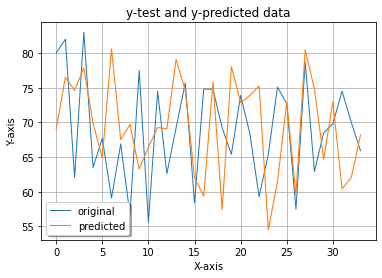

In [54]:
x_ax = range(len(y_test))
plt.plot(x_ax, y_test, linewidth=1, label="original")
plt.plot(x_ax, y_pred, linewidth=1.1, label="predicted")
plt.title("y-test and y-predicted data")
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend(loc='best',fancybox=True, shadow=True)
plt.grid(True)
plt.show() 

# Summary and Recommendations

As we can see there are relationships between foods that people eat, their education, where they live, their BMI, and their life expectancy.

While this is the case, my hypothesis that food greatly influences a person's life expectancy worldwide is a bit off. We can see from the above data that food does affect a person's longevity, but other factors give much more influence.

We were able to determine that those who eat a diet of no animal products do have a greater lifespan, but this is not as large of a relationship as was initially thought our data would show.

We can take the data and find enough correlations to reach a close accuracy of predicting a person's lifespan. It is interesting that how educated a person is and where they live in the world still affects a person's lifespan greater than what they eat.
The next steps to take would be looking at newer data of this variety to see if the correlations I found would be true while using another dataset.

We could use this data to try and equalize the life expectancy gap in places where people simply live shorter lifespans due to global location or education.

Is it feasible or possible to level the playing field of people around the globe based on location or education, when it comes to life expectancy?
